In [1]:
import torchvision
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader 

# **Data Preprocessing**

In [2]:
dataset = MNIST(root='Data/',download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw



Label: 5


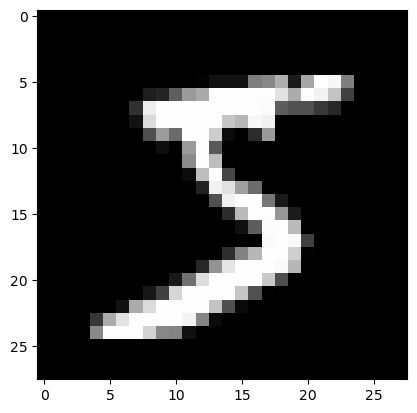

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
image,label = dataset[0]
print("Label:",label)
plt.imshow(image,cmap='gray')

In [4]:
dataset = MNIST(root='Data/',train=True,transform=ToTensor())

In [5]:
image,label = dataset[0]
print("Label:",label)

Label: 5


In [6]:
#Split the dataset into train and validation 


def Split_indices(n,val_pct):
  #Number of images in validation dataset
  n_val = int(val_pct*n)
  #create a random permutation 0 to n-1
  indxs = np.random.permutation(n)
  #pick first n_val indices for validation
  return indxs[n_val:],indxs[:n_val]


In [7]:
train_indices,valid_indices = Split_indices(len(dataset),0.2)

print("Training dataset size:",len(train_indices))
print("Testing dataset size:",len(valid_indices))

Training dataset size: 48000
Testing dataset size: 12000


In [8]:
#Train sampler and dataloader
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,batch_size,sampler = train_sampler)

valid_sampler = SubsetRandomSampler(valid_indices)
valid_dl = DataLoader(dataset,batch_size,sampler = valid_sampler)



# **Model**

In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [10]:
class MnistModel(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        #Hidden layer
        self.linear1 = nn.Linear(in_size,hidden_size)
        #Output layer
        self.linear2 = nn.Linear(hidden_size,out_size)
    def forward(self,xb):
        #Flatten the image tensor
        xb = xb.view(xb.size(0),-1)
        #Pass the input through first layer
        out = self.linear1(xb)
        #Apply activation function
        out = F.relu(out)
        #Pass the output as a input to output layer
        out = self.linear2(out)
        return out
    
        
        
        

Let Create a Model with 64 activation

In [11]:
input_size = 784
number_class = 10

model = MnistModel(input_size,hidden_size = 64,out_size=number_class)


Print the weight and bias matrix for each of the layers

In [12]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


Let, try to generate some output using our model

In [13]:
for image,label in train_dl:
    out = model(image)
    loss = F.cross_entropy(out,label)
    print("Loss:",loss.item())
    break
    

Loss: 2.3346521854400635


# **Using a GPU**

In [14]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [15]:

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

In [16]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [17]:
#Move data to GPU
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


Finally,we define a DeviceDataLoader class to rap over exesting dataloader and move data to selected device

In [18]:
class DeviceDataloader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        '''yield a batch of data after moving it to device'''
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [19]:
train_dl = DeviceDataloader(train_dl,device)
valid_dl = DeviceDataloader(valid_dl,device)


# **Training**

In [20]:

def loss_batch(model,loss_fn,xb,yb,opt=None,metric = None):
    #Generate Prediction
    preds = model(xb)
    #Calculate the loss
    loss = loss_fn(preds,yb)
    if opt is not None:
        #Compute gradient
        loss.backward()
        #Update Parameters
        opt.step()
        #Reset gradient
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds,yb)
    return loss.item(), len(xb),metric_result
  
 
  

In [21]:
def evaluate(model,loss_fn,valid_dl,metric=None):
    with torch.no_grad():
       #Pass each batch through the model
        result = [loss_batch(model, loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
        #separete losses, counts and metrics
        losses, nums, metrics = zip(*result)
        #Total size of the dataset
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses,nums))/total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics,nums))/total
    return avg_loss,total, avg_metric   

In [22]:
def accuracy(outputs,labels):
    _, pred = torch.max(outputs,dim=1)
    return torch.sum(pred==labels).item()/len(pred)

In [23]:
def fit(epoches,lr,model, loss_fn, train_dl, valid_dl,opt_fun=None, metric=None):
    losses,metrics =  [], []

    if opt_fun==None:
        opt_fun = torch.optim.SGD
    opt = opt_fun(model.parameters(),lr=lr)    
    for epoch in range(epoches):
        #Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model,loss_fn,xb,yb,opt)
        #Evaluation
        result = evaluate(model,loss_fn, valid_dl,metric)
        val_loss, total , val_metric = result
        #Record the loss and metric
        losses.append(val_loss)
        metrics.append(val_metric)
        #Print progress
        if metric is None:
            print('Epoch[{}/{}],loss: {:.4f}'.format(epoch+1,epoches,val_loss))   
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1,epoches,val_loss,metric.__name__,val_metric))
     
    return losses,metrics
     
    
  

In [24]:
#Train the model on GPU

model = MnistModel(input_size,hidden_size=128,out_size = number_class)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

Train the model with 5 epoches and 0.5 learning rate

In [25]:
losses1,metices1 = fit(5,0.5, model, F.cross_entropy,train_dl,valid_dl,None,accuracy)

Epoch [1/5], Loss: 0.1845, accuracy: 0.9473
Epoch [2/5], Loss: 0.1328, accuracy: 0.9613
Epoch [3/5], Loss: 0.1201, accuracy: 0.9645
Epoch [4/5], Loss: 0.0988, accuracy: 0.9694
Epoch [5/5], Loss: 0.0881, accuracy: 0.9731


Let's see how the model performs on the validation set with the initial set of weights and biases.

Train the model with 10 epoches with 0.00001 learning rates

In [26]:
losses2,metices2 = fit(20,0.00001, model, F.cross_entropy,train_dl,valid_dl,None,accuracy)

Epoch [1/20], Loss: 0.0881, accuracy: 0.9731
Epoch [2/20], Loss: 0.0880, accuracy: 0.9731
Epoch [3/20], Loss: 0.0880, accuracy: 0.9731
Epoch [4/20], Loss: 0.0880, accuracy: 0.9731
Epoch [5/20], Loss: 0.0880, accuracy: 0.9731
Epoch [6/20], Loss: 0.0880, accuracy: 0.9731
Epoch [7/20], Loss: 0.0880, accuracy: 0.9731
Epoch [8/20], Loss: 0.0880, accuracy: 0.9731
Epoch [9/20], Loss: 0.0879, accuracy: 0.9731
Epoch [10/20], Loss: 0.0879, accuracy: 0.9732
Epoch [11/20], Loss: 0.0879, accuracy: 0.9732
Epoch [12/20], Loss: 0.0879, accuracy: 0.9732
Epoch [13/20], Loss: 0.0879, accuracy: 0.9733
Epoch [14/20], Loss: 0.0879, accuracy: 0.9733
Epoch [15/20], Loss: 0.0879, accuracy: 0.9735
Epoch [16/20], Loss: 0.0878, accuracy: 0.9735
Epoch [17/20], Loss: 0.0878, accuracy: 0.9736
Epoch [18/20], Loss: 0.0878, accuracy: 0.9736
Epoch [19/20], Loss: 0.0878, accuracy: 0.9736
Epoch [20/20], Loss: 0.0878, accuracy: 0.9736


Plot the accuracy

Text(0.5, 1.0, 'Accuracy Vs Epoch')

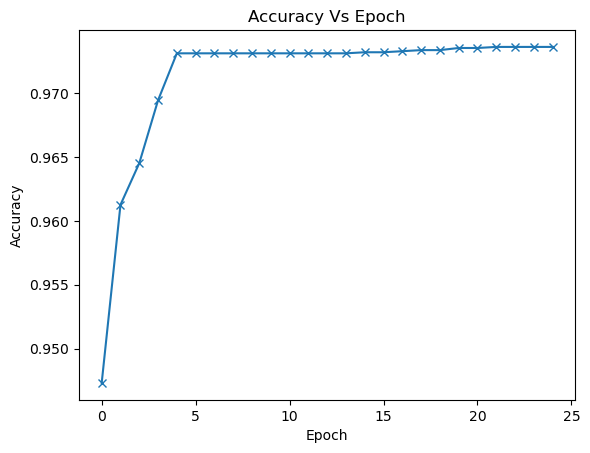

In [27]:
accuracies =metices1+metices2
plt.plot(accuracies,'-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy Vs Epoch")

Plot the loss Vs Epoch graph